# Nozzles (part I)

In [1]:
# Necessary modules to solve problems
import numpy as np
from scipy.optimize import root_scalar

# Pint gives us some helpful unit conversion
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity # We will use this to construct quantities (value + unit)

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# these lines are only for helping improve the display
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 300
plt.rcParams['savefig.dpi'] = 300

## Converging nozzles

Let's now take our understanding of isentropic flows in varying-area ducts and apply them to converging nozzles.

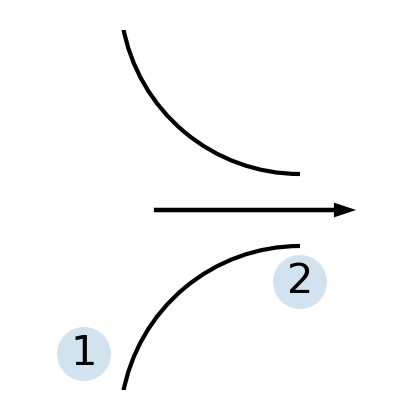

In [3]:
from matplotlib.patches import Arc

fig, ax = plt.subplots(figsize=(1.5,1.5),subplot_kw={'aspect': 'equal'})
arc = Arc([1,1.1], 1, 1, theta1=190, theta2=270)
ax.add_patch(arc)
arc = Arc([1,-0.1], 1, 1, theta1=90, theta2=170)
ax.add_patch(arc)

ax.set_xlim(0.25, 1.25)
ax.set_ylim(0, 1)
ax.axis('off')

cc = plt.Circle((1.0, 0.3), 0.075, alpha=0.2)
ax.add_artist(cc)
cc = plt.Circle((0.4, 0.1), 0.075, alpha=0.2)
ax.add_artist(cc)
ax.text(1.0, 0.3, '2', horizontalalignment='center', verticalalignment='center')
ax.text(0.4, 0.1, '1', horizontalalignment='center', verticalalignment='center')

ax.arrow(0.6, 0.5, 0.5, 0, head_width=0.025, color='k')

fig.tight_layout()
plt.show()

Consider a converging-only nozzle, from a large supply of air at 300 K and 10 bar to a receiver with variable pressure $p_{\text{rec}}$ that we can control.

Since the supply tank has such a large cross-sectional area compared to the nozzle, we can assume that the velocity is approximately zero, and so that is the stagnation state:

\begin{gather*}
T_1 = T_{t1} \\
p_1 = p_{t1} \;.
\end{gather*}

From the energy equation, stagnation enthalpy and temperature are constant:

\begin{gather*}
h_{t1} + q = h_{t2} + w_s \\
h_{t1} = h_{t2} \\
\rightarrow T_{t1} = T_{t2} \;.
\end{gather*}

Clearly, the receiver pressure $p_{\text{rec}}$ controls the flow.

In [4]:
gamma = 1.4
pt1 = Q_(10.0, 'bar')
Tt1 = Q_(300, 'K')
gas_constant_air = Q_(287, 'J/(kg*K)')

In [5]:
def stagnation_pressure(mach, gamma):
    '''Calculate ratio of static to stagnation pressure'''
    return (1 + 0.5*(gamma - 1)*mach**2)**(-gamma/(gamma - 1))

def stagnation_temperature(mach, gamma):
    '''Calculate ratio of static to stagnation temperature'''
    return 1.0 / (1.0 + 0.5*(gamma - 1)*mach**2)

def find_mach_pressure(mach, pressure_ratio, gamma):
    '''Used to find Mach number for given stagnation pressure and gamme'''
    return (pressure_ratio - stagnation_pressure(mach, gamma))

def find_mach_temperature(mach, temperature_ratio, gamma):
    '''Used to find Mach number for given stagnation temperature and gamme'''
    return (temperature_ratio - stagnation_temperature(mach, gamma))

### 1. No flow

If $p_{\text{rec}} = 10$ bar, then there is no flow through the nozzle.

### 2. Isentropic expansion

If $p_{\text{rec}} < 10$ bar, then the gas will accelerate through the nozzle as it expands isentropically and the pressure drops until $p = p_{\text{rec}}$ at the exit.
We can use the pressure ratio to find the exit Mach number and temperature.

For example, if $p_{\text{rec}} = 8.02$ bar:

\begin{align*}
\frac{p_2}{p_{t2}} &= \frac{p_2}{p_{t1}} \frac{p_{t1}}{p_{t2}} = f(\gamma, M_2) \\
&= \frac{8.02}{10} \left( 1 \right) = 0.802 \;,
\end{align*}

where $\frac{p_{t1}}{p_{t2}} = 1$ since the flow is isentropic.

In [6]:
p2 = Q_(8.02, 'bar')
pt2 = pt1
Tt2 = Tt1

p2_pt2 = (p2 / pt1) * (pt1 / pt2)

root = root_scalar(find_mach_pressure, x0=0.1, x1=0.2, args=(p2_pt2, gamma))
M2 = root.root
print(f'M2 = {M2:.3f}')

T2_Tt2 = stagnation_temperature(M2, gamma)
T2 = T2_Tt2 * Tt2
print(f'T2 = {T2: .1f}')

a2 = np.sqrt(gamma * gas_constant_air * T2)
V2 = a2 * M2
print(f'V2 = {V2.to("m/s"): .1f}')

M2 = 0.570 dimensionless
T2 = 281.7 kelvin
V2 = 191.9 meter / second


### 3. Critical pressure

Let's examine when we lower the receiver pressure to $p_{\text{rec}} = 5.283$ bar:

\begin{align*}
\frac{p_2}{p_{t2}} &= \frac{p_2}{p_{t1}} \frac{p_{t1}}{p_{t2}} = f(\gamma, M_2) \\
&= \frac{5.283}{10} \left( 1 \right) = 0.5283 \;.
\end{align*}

In [7]:
p2 = Q_(5.283, 'bar')
pt2 = pt1
Tt2 = Tt1

p2_pt2 = (p2 / pt1) * (pt1 / pt2)

root = root_scalar(find_mach_pressure, x0=0.1, x1=0.2, args=(p2_pt2, gamma))
M2 = root.root
print(f'M2 = {M2:.3f}')

M2 = 1.000 dimensionless


For this nozzle, $p_{\text{rec}} = 5.283$ bar is the **critical pressure**,
where the velocity leaving the nozzle is sonic.

Now, what if we tried to reduce the receiver pressure below this critical pressure? 
Mathematically this corresponds to a supersonic velocity, but we know that a converging-only nozzle *cannot* increase the velocity past the sonic point. So, that means that further reducing the receiver pressure has *no effect* on the flow inside the nozzle.

Thus, once the critical pressure is reached, the flow is **choked**.

We can find the critical pressure ratio:

$$
\frac{p_{\text{crit}}}{p_t} = \left(\frac{1}{1+\frac{\gamma-1}{2}}\right)^{\gamma/(\gamma-1)} = \left(\frac{2}{\gamma+1}\right)^{\gamma/(\gamma-1)} \;.
$$

If the receiver pressure is below the critical pressure ($p_{\text{rec}} < p_{\text{crit}}$), then the flow is choked.

## Example: mass flow in converging nozzle

Air flows from a large reservoir through a converging nozzle with an exit area of 50 cm$^2$.
The reservoir is large enough that the supply temperature and pressure remain approximately constant at 500 kPa and 400 K as the flow exhausts through the nozzle. Assuming isentropic flow of air as an ideal gas with a constant ratio of specific heats ($\gamma = 1.4$).
Plot the mass flow rate for a range of back pressures from 0 to 500 kPa.

First, find the critical pressure for this nozzle, and the temperature associated with that pressure:

In [8]:
gamma = 1.4
gas_constant_air = Q_(287, 'J/(kg*K)')

exit_area = Q_(50, 'cm^2')
pt = Q_(500, 'kPa')
Tt = Q_(400, 'K')
back_pressures = Q_(np.linspace(0, 500, 15, endpoint=True), 'kPa')

p_crit = pt * (2 / (gamma+1))**(gamma/(gamma-1))
print(f'Critical pressure = {p_crit: .2f}')

T_crit = Tt * stagnation_temperature(1.0, gamma)
print(f'Exit temperature = {T_crit: .2f}')

Critical pressure = 264.14 kilopascal
Exit temperature = 333.33 kelvin


We can find the mass flow rate with

\begin{align*}
\dot{m} &= \rho_e A_e V_e \\
&= \left(\frac{p_e}{R T_e} \right) A_e \left( M_e \sqrt{\gamma R T_e} \right) \;.
\end{align*}

For back pressures that are higher than the critical pressure, we can use the stagnation pressure ratio to find the corresponding exit Mach number, and then the other properties.

For back pressures that are lower than the critical pressure, the exit conditions are locked at the critical conditions and the Mach number is one.

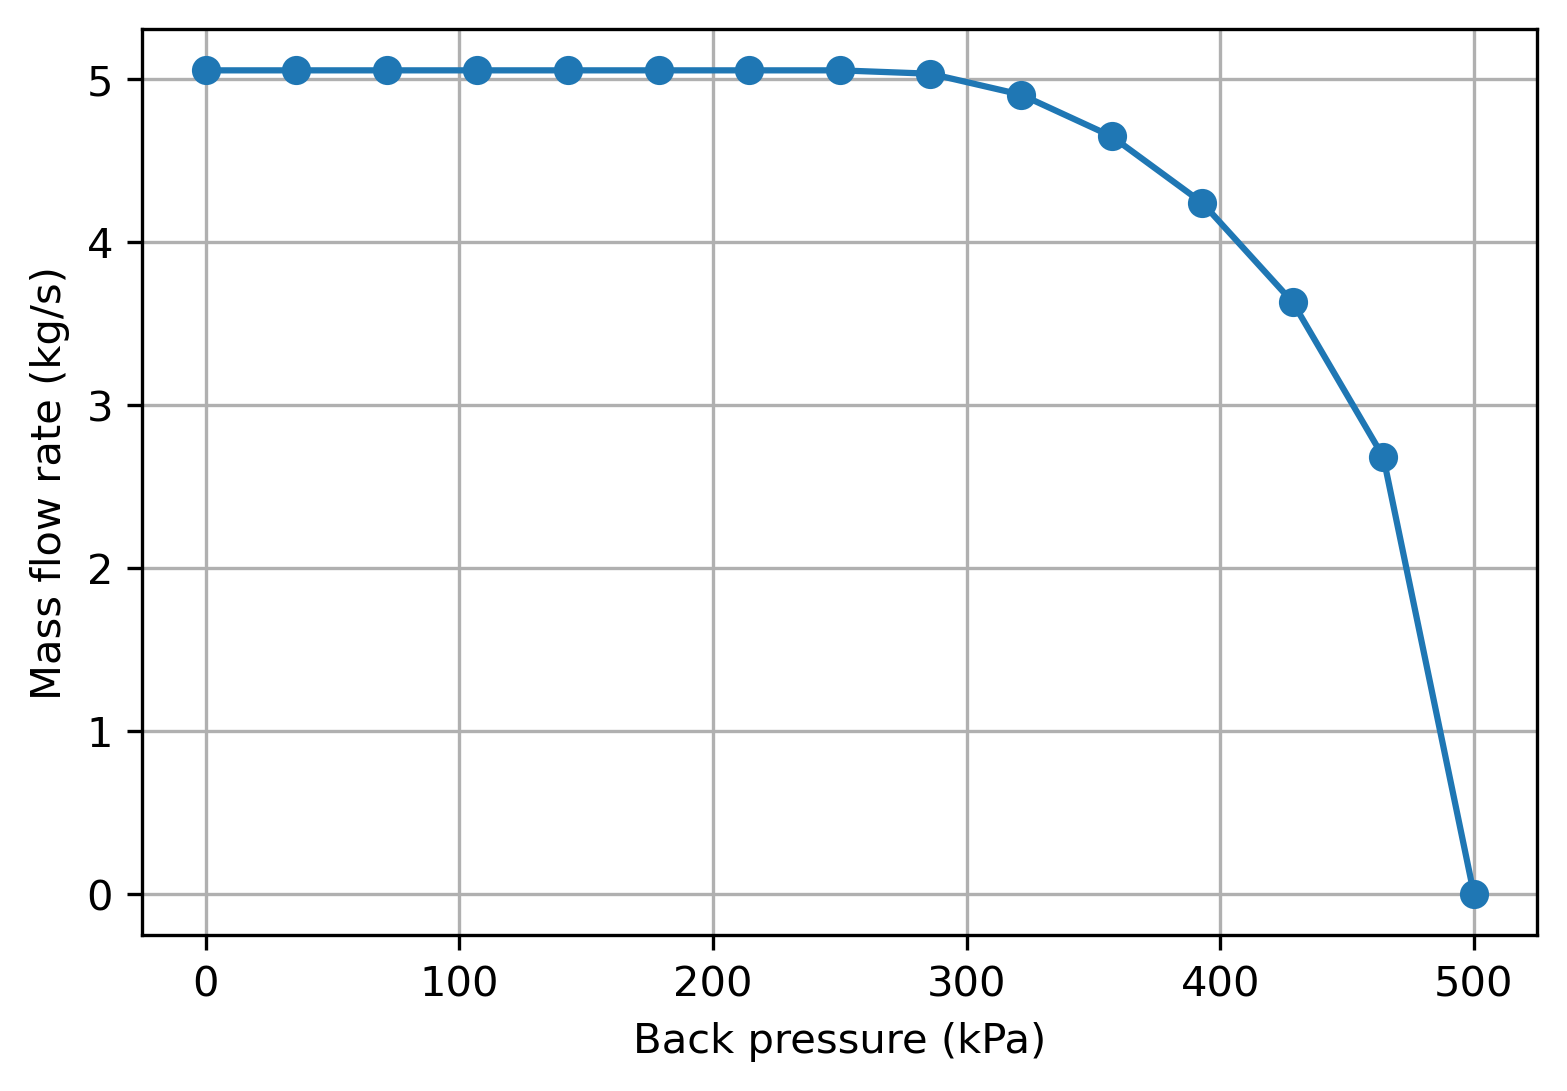

Max flow rate: 5.052 kilogram / second


In [9]:
mass_flow_rates = Q_(np.zeros_like(back_pressures), 'kg/s')
for idx, p in enumerate(back_pressures):
    if p > p_crit:
        root = root_scalar(find_mach_pressure, x0=0.1, x1=0.2, args=(p/pt, gamma))
        Me = root.root
        
        pe = pt * stagnation_pressure(Me, gamma)
        Te = Tt * stagnation_temperature(Me, gamma)
        mass_flow_rates[idx] = (
            pe * exit_area * Me * np.sqrt(gamma * gas_constant_air * Te) / 
            (gas_constant_air * Te)
            ).to('kg/s')
    else:
        mass_flow_rates[idx] = (
            p_crit * exit_area * np.sqrt(gamma * gas_constant_air * T_crit) / 
            (gas_constant_air * T_crit)
            ).to('kg/s')

plt.plot(back_pressures.to('kPa').magnitude, mass_flow_rates.magnitude, 'o-')
plt.xlabel('Back pressure (kPa)')
plt.ylabel('Mass flow rate (kg/s)')
plt.grid()
plt.show()

print(f'Max flow rate: {np.max(mass_flow_rates): .3f}')

## Converging-diverging nozzles

Converging-diverging nozzles, also known as de Laval nozzles, are designed to obtain a supersonic flow. The "correct" or design operation is for subsonic flow between points 1 and 2, reaching sonic flow at location 2 (the throat), and then isentropic supersonic flow in the diverging section from points 2 to 3.

Consider a converging-diverging nozzle, exhausting air from a supply tank at 300 K and 10 bar to a receiver with variable pressure $p_{\text{rec}}$ that we can control.
The **area ratio**, or the ratio of the exit area to the throat area ($\frac{A_3}{A_2}$), is 2.494.

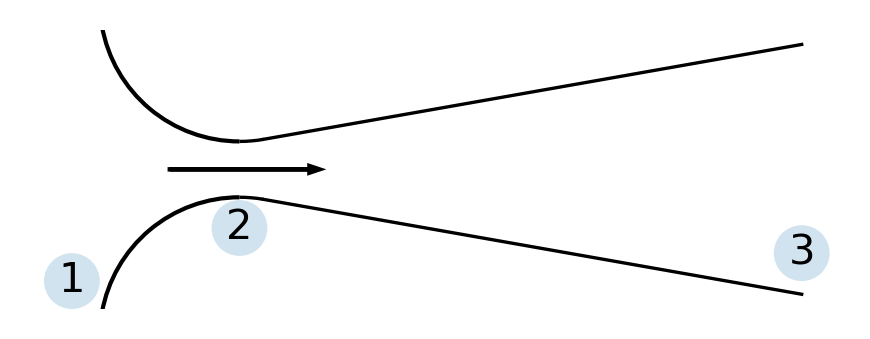

In [10]:
# plot a converging-diverging nozzle with a conical diverging section
# formulas based on http://seitzman.gatech.edu/classes/ae6450/nozzle_geometries.pdf
from matplotlib.patches import Arc
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(3,3),subplot_kw={'aspect': 'equal'})
arc = Arc([1,1.1], 1, 1, theta1=190, theta2=270)
ax.add_patch(arc)
arc = Arc([1,-0.1], 1, 1, theta1=90, theta2=170)
ax.add_patch(arc)

cc = plt.Circle((1.0, 0.29), 0.1, alpha=0.2)
ax.add_artist(cc)
cc = plt.Circle((0.4, 0.1), 0.1, alpha=0.2)
ax.add_artist(cc)
ax.text(1.0, 0.29, '2', horizontalalignment='center', verticalalignment='center')
ax.text(0.4, 0.1, '1', horizontalalignment='center', verticalalignment='center')

R1 = 0.5
Rt = 0.1
alpha = 10 # degrees
epsilon = 20
L1 = R1 * np.sin(alpha * np.pi/180)
Re = np.sqrt(epsilon) * Rt
RN = Rt + R1 * (1 - np.cos(alpha*np.pi/180))
LN = (Re - RN) / np.tan(alpha * np.pi/180)

arc = Arc([1,1.1], 1, 1, theta1=270, theta2=(270+alpha), linewidth=0.8)
ax.add_patch(arc)
arc = Arc([1,-0.1], 1, 1, theta1=(90-alpha), theta2=90, linewidth=0.8)
ax.add_patch(arc)

# lines start at x=1, y=0.5
plt.plot([1+L1, 1+L1+LN], [0.5+RN, 0.5+Re], '-', color='k', linewidth=0.8)
plt.plot([1+L1, 1+L1+LN], [0.5-RN, 0.5-Re], '-', color='k', linewidth=0.8)

cc = plt.Circle((1+L1+LN, 0.2), 0.1, alpha=0.2)
ax.add_artist(cc)
ax.text(1+L1+LN, 0.2, '3', horizontalalignment='center', verticalalignment='center')

ax.arrow(0.75, 0.5, 0.5, 0, head_width=0.025, color='k')

ax.set_xlim(0.25, 3.15)
ax.set_ylim(0, 1)
ax.axis('off')

fig.tight_layout()
plt.show()

### Design operation: third critical

The design operation of a converging-diverging nozzle is supersonic flow at the exit, and fully isentropic throughout.

We can use the sonic reference area to find the supersonic Mach number associated with this condition:

\begin{align*}
\frac{A_3}{A_3^*} &= \frac{A_3}{A_2} \frac{A_2}{A_2^*} \frac{A_2^*}{A_3^*} \\
&= (2.494) \left(1 \right) \left( 1 \right) = 2.494 \;,
\end{align*}

which is a function of $M_3$. $\frac{A_2}{A_2^*} = 1$ because the velocity is sonic at the throat, and $\frac{A_2^*}{A_3^*} = 1$ because the flow is isentropic in the diverging section.

With $M_3$ we can obtain the stagnation pressure ratio at the exit:

$$
p_3 = \frac{p_3}{p_{t3}} \frac{p_{t3}}{p_{t1}} p_{t1} \;.
$$

In [11]:
def reference_area(mach, gamma):
    '''Calculate reference area ratio'''
    return ((1.0/mach) * ((1 + 0.5*(gamma-1)*mach**2) / 
            ((gamma + 1)/2))**((gamma+1) / (2*(gamma-1)))
            )

def find_mach_area(mach, area_ratio, gamma):
    '''Used to find Mach number for given reference area ratio and gamma'''
    return (area_ratio - reference_area(mach, gamma))

In [12]:
A3_A2 = 2.494
pt3 = pt1

root = root_scalar(find_mach_area, x0=2, x1=2.5, args=(A3_A2, gamma))
M_third = root.root
print(f'M3 = {M_third: .2f}')

p3_pt3 = stagnation_pressure(M_third, gamma)
p_third = p3_pt3 * (pt3/pt1) * pt1
print(f'p3 = {p_third: .3f}')

M3 =  2.44
p3 = 0.642 bar


This is the **third critical** operating point of the nozzle, which is the design operation.

### First critical

The **first critical** operating point is associated with subsonic exhaust, but choked flow, so the velocity is sonic at the throat.

In [13]:
root = root_scalar(find_mach_area, x0=0.1, x1=0.2, args=(A3_A2, gamma))
M_first = root.root
print(f'M3 = {M_first: .2f}')

p3_pt3 = stagnation_pressure(M_first, gamma)
p_first = p3_pt3 * (pt3/pt1) * pt1
print(f'p3 = {p_first: .3f}')

M3 =  0.24
p3 = 9.607 bar


Above the first critical point, the nozzle acts like a Venturi tube, which can be used to relate the pressure drop to flow rate.

Below the first critical point, the nozzle is choked and the conditions from the inlet to the throat do not change.

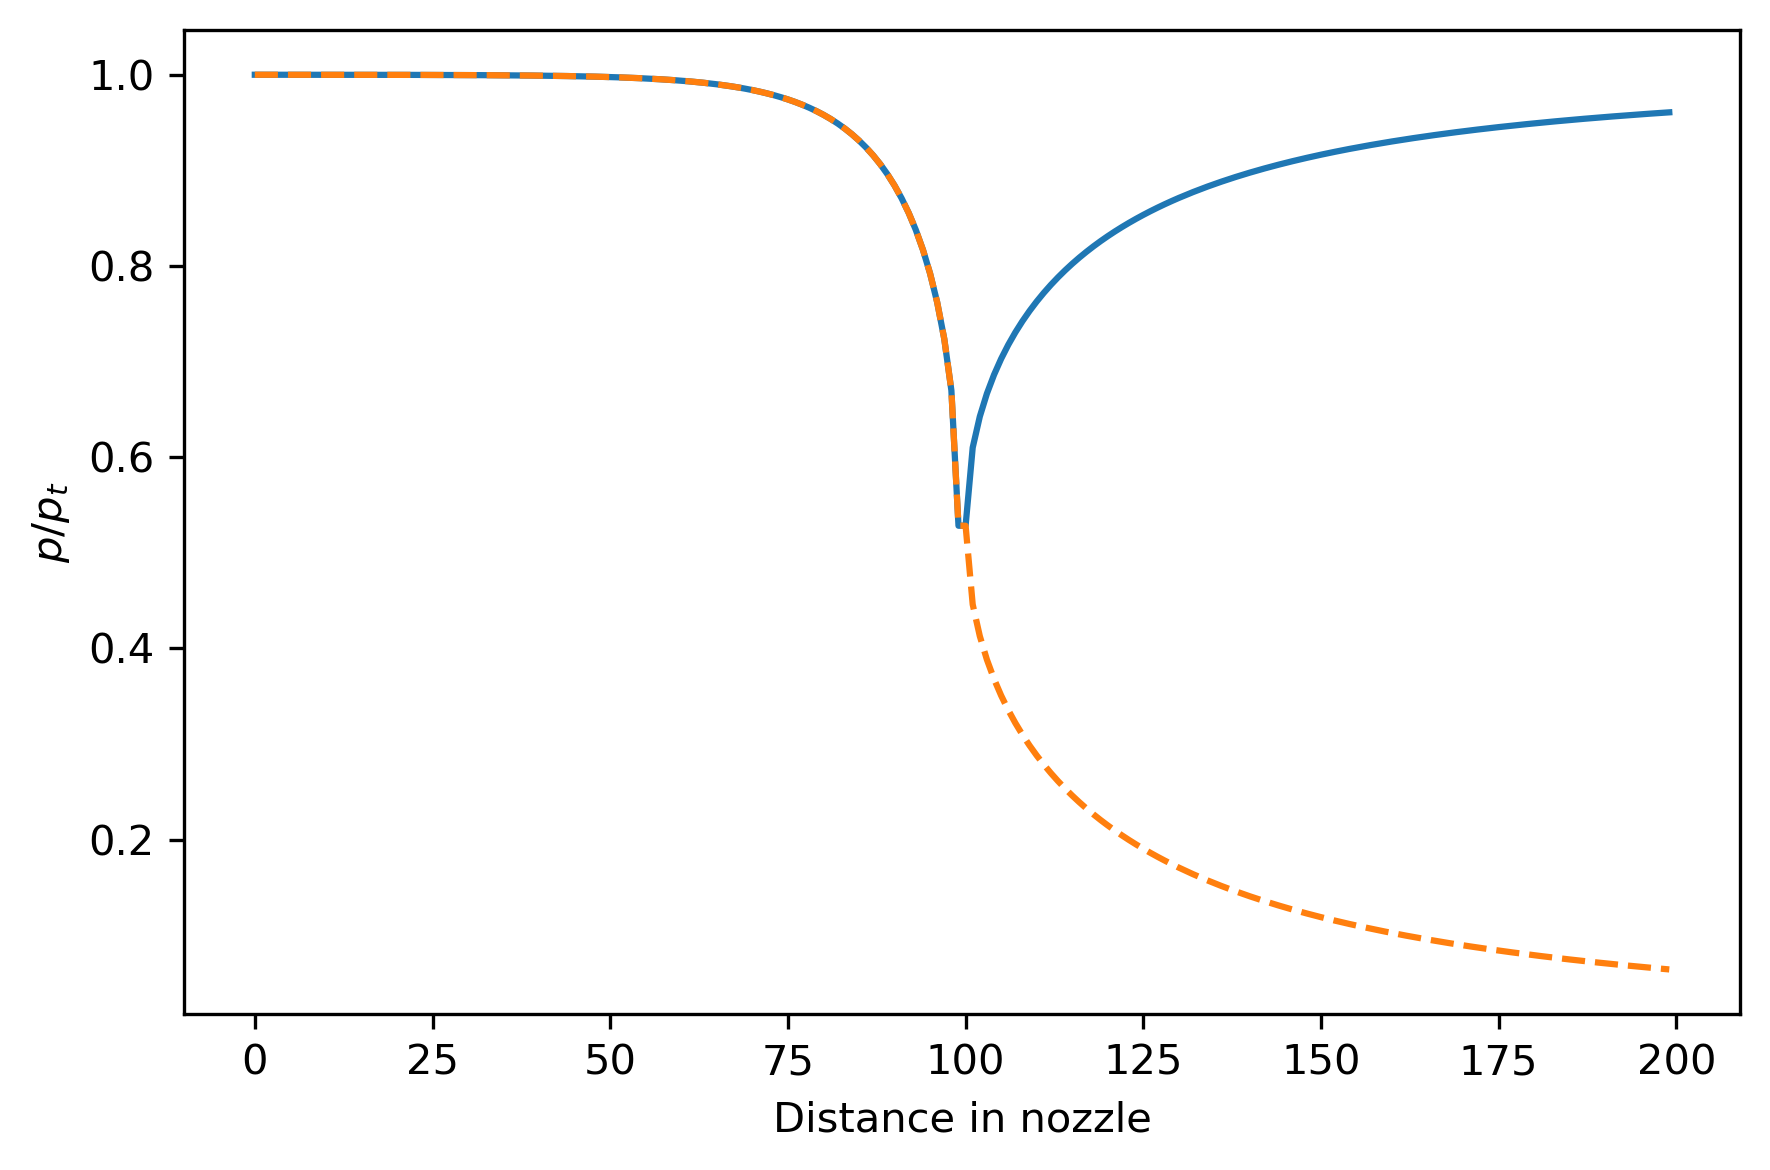

In [16]:
area_ratios_converging = np.logspace(2, 0, 100, endpoint=True)
area_ratios_diverging = np.linspace(1.0, A3_A2, 100, endpoint=True)

pressures_converging = np.zeros_like(area_ratios_converging)
machs_converging = np.zeros_like(area_ratios_converging)
for idx, area_ratio in enumerate(area_ratios_converging):
    root = root_scalar(
        find_mach_area, x0=0.1, x1=0.15, bracket=(0.001,1.0), args=(area_ratio, gamma)
        )
    machs_converging[idx] = root.root
    pressures_converging[idx] = stagnation_pressure(machs_converging[idx], gamma)

pressures_first = np.zeros_like(area_ratios_diverging)
pressures_third = np.zeros_like(area_ratios_diverging)
for idx, area_ratio in enumerate(area_ratios_diverging):
    root = root_scalar(
        find_mach_area, x0=0.1, x1=0.2, bracket=(0.001,1.0), args=(area_ratio, gamma)
        )
    pressures_first[idx] = stagnation_pressure(root.root, gamma)
    
    root = root_scalar(
        find_mach_area, x0=2.5, x1=3.0, bracket=(1.0,10.0), args=(area_ratio, gamma)
        )
    pressures_third[idx] = stagnation_pressure(root.root, gamma)

pressures_first = np.concatenate((pressures_converging, pressures_first))
pressures_third = np.concatenate((pressures_converging, pressures_third))

fig, ax = plt.subplots()
ax.plot(pressures_first, '-')
ax.plot(pressures_third, '--')

ax.set_ylabel(r'$p/p_t$')
ax.set_xlabel('Distance in nozzle')

fig.tight_layout()
plt.show()

## Nozzle performance

The efficiency of a nozzle is described by the actual increase in kinetic energy normalized by the ideal increase in kinetic energy:

$$
\eta_n \equiv \frac{\text{actual } \Delta \text{KE}}{\text{ideal } \Delta \text{KE}} \;.
$$

We can express this using more convenient quantities by examining the energy equation:

\begin{gather*}
h_{t1} + q = h_{t2} + w_s \\
h_{t1} = h_{t2} \\
h_1 + \frac{V_1^2}{2} = h_2 + \frac{V_2^2}{2} \\
h_1 - h_2 = \frac{V_2^2 - V_1^2}{2} = \Delta \text{KE}
\end{gather*}

so

$$
\eta_n = \frac{\Delta h_{\text{actual}}}{\Delta h_{\text{ideal}}} = \frac{h_1 - h_2}{h_1 - h_{2s}} \;,
$$

where subscripts 1 and 2 indicate the inlet and outlet, and subscript $s$ indicates the ideal (i.e., isentropic) outlet condition.

The performance of nozzles is also sometimes described using a **velocity coefficient**, which relates the actual outlet velocity to the ideal outlet velocity:

$$
C_v \equiv \frac{V_2}{V_{2s}} \;,
$$

and a **discharge coefficient**, which relates the actual mass flow rate to the ideal mass flow rate:

$$
C_d \equiv \frac{\dot{m}}{\dot{m}_s} \;.
$$

## Diffuser performance

Although most of our analysis has focused on nozzles, diffusers behave the same—just opposite!
The purpose of a diffuser is to convert kinetic energy into pressure energy.

One common performance metric is the **total-pressure recovery factor**, which is the ratio of the outlet stagnation pressure to the inlet stagnation pressure:

$$
\eta_r \equiv \frac{p_{t2}}{p_{t1}} = e^{-\Delta s / R} = \frac{A_1^*}{A_2^*} \;.
$$

The diffuser efficiency is represented by the ratio of the actual pressure rise to the ideal pressure rise:

$$
\eta_d \equiv \frac{p_2 - p_1}{p_{2s} - p_1} \;.
$$